In [1]:
from sklearn.decomposition import PCA
import cv2, os
from scipy.io import loadmat

import numpy as np
import matplotlib.pyplot as plt
import cv2, os
from scipy import ndimage
import torch
from tqdm import tqdm

In [2]:
colors = ['white','green','red','blue','cyan','yellow','magenta']
proj_H, proj_W = 360, 640
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작

n_illum = len(colors)
m_n = 3
wvls_n = 24

patch_idx = np.arange(0, 24)
patch_size = 3

data = "hdr_datas/procam_ssfm"
illum_name = "procam"

data_dir = '../dataset/%s/'%data
illum_dir = '../dataset/image_formation/illum/%s/'%illum_name

n_illum = len(os.listdir(illum_dir))

### Data load

In [3]:
munsell_data = loadmat('../dataset/munsell380_800_1.mat')

In [4]:
munsell = munsell_data['munsell']
S = munsell_data['S']
C = munsell_data['C']

# bring only 430 to 660 at 5nm interval
munsell_430_660 = munsell[50:-138][::10]

In [5]:
# plt.plot(munsell[:,0])

### PCA find basis

In [6]:
pca = PCA(n_components=8) 
pca.fit(munsell_430_660.T)

PCA(n_components=8)

In [7]:
pca.components_.shape

(8, 24)

In [8]:
# import pickle
# with open("munsell_basis.pkl", "wb") as file:
#     pickle.dump(pca, file)

### Illumination picking

In [9]:
illums = np.array([cv2.imread(os.path.join('../dataset/image_formation/illum/line_pattern_5', 'illum_%03d.png'%i),-1)/255 for i in range(318)])

In [10]:
uv1 = np.load('../dataset/uv1.npy') # m, wvl, uv1, # of pixel
valid_idx = np.load('valid_idx.npy')
valid_mask = np.load('valid_mask.npy')

In [11]:
valid_idx[~valid_mask] = -1
valid_idx_final = valid_idx.reshape(m_n, wvls_n, cam_H, cam_W)

In [12]:
valid_mask_reshape = valid_mask.reshape(m_n, wvls_n, cam_H, cam_W)

### Bring zero order data

In [13]:
hdr_imgs = np.array([cv2.imread('../dataset/hdr_datas/procam_ssfm/capture_%04d.png'%i, -1)[:,:,::-1] for i in range(n_illum)])

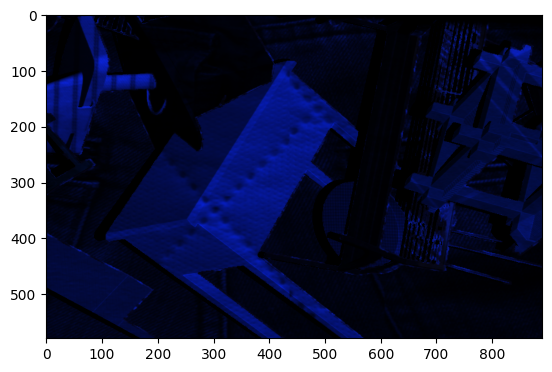

In [14]:
c_idx = 3
plt.imshow(hdr_imgs[c_idx])

### Make hdr

In [15]:
idx_minmax = 1
fn_exp = np.array([160, 320])

# exposure times
ex_time = np.array([0.1, 0.9])
ex_min = ex_time[idx_minmax]
exposure = ex_time / ex_min

In [16]:
invalid_intensity_ratio = 0.01 # 0 < invalid_intensity_ratio: invalid,  out of 1

max_intensity = 8000
weight_trapezoid = np.zeros(max_intensity)
intv = float(max_intensity) * invalid_intensity_ratio

for i in range(max_intensity):
    if i < intv:
        weight_trapezoid[i] = 0  
    elif i < intv * 2:
        weight_trapezoid[i] = (i - intv) / intv
    elif i < max_intensity - (intv * 2):
        weight_trapezoid[i] = 1
    elif i < max_intensity - intv:
        weight_trapezoid[i] = (max_intensity - intv - i) / intv
    else:
        weight_trapezoid[i] = 0

In [17]:
def make_hdr(ldr_images, weight_trapezoid, exposure):

    weighted_images = [weight_trapezoid[image] for image in ldr_images]
    
    # exposure normalization
    radiance_images = [np.multiply(weighted_images[i], ldr_images[i] / (exposure[i])) for i in range(len(ldr_images))]

    # intensity normalization
    weight_sum_image = np.sum(weighted_images, axis=0)
    radiance_sum_image = np.sum(radiance_images, axis=0)

    idx_invalid = (weight_sum_image == 0)
    weight_sum_image[idx_invalid] = 1
    radiance_sum_image[idx_invalid] = 0    
    
    return np.divide(radiance_sum_image, weight_sum_image), idx_invalid, weight_sum_image

In [18]:
hdr_imgs = np.zeros(shape = (len(colors), cam_H, cam_W, 3))

# erase black image and get hdr image
for c in range(len(colors)):
    # erase black image and get hdr image
    ldr_path = os.path.join(data_dir, 'step2_%sms_crop/capture_%04d.npy')
    
    # ldr_images = np.array([cv2.imread(ldr_path%(k, c), -1)[:,:,::-1] for k in fn_exp]) 
    ldr_images = np.round(np.array([np.load(ldr_path%(k, c)) for k in fn_exp])).astype(np.int16)
            
    hdr_img, invalid_map, weight_map = make_hdr(ldr_images, weight_trapezoid, exposure)
    
    if i % 10 == 0:
        print('%03d-th finished'%i)

    hdr_imgs[c] = hdr_img

    print('color %s finished'%colors[c])

hdr_imgs = np.array(hdr_imgs)

color white finished
color green finished
color red finished
color blue finished
color cyan finished
color yellow finished
color magenta finished


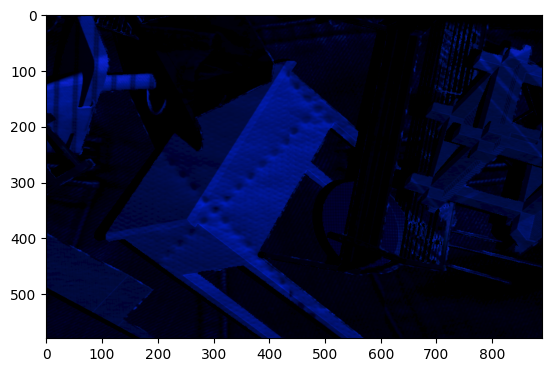

In [19]:
idx = 3
plt.imshow(hdr_imgs[idx]/(255*9)) # 0.9 / 0.1 = 9

In [20]:
hdr_imgs[2].max()

1977.5

### Iterative Optimization

#### PEF, CRF, DG Efficiency

In [21]:
PEF = np.load('../dataset/image_formation/PEF_update.npy')[::2]
CRF = np.load('../dataset/image_formation/CRF_update.npy')[::2] # from 430nm
DG_efficiency = np.load('../dataset/image_formation/DG_update.npy')[:,::2] # from 430nm
new_wvls = torch.linspace(430*1e-9, 660*1e-9, 24) # 400 ~ 680 까지 10nm 간격으로

#### Median filter

In [22]:
hdr_imgs_filtered_array = np.zeros(shape = (len(colors), cam_H, cam_W, 3), dtype = np.float64)

for c in range(len(colors)):
    hdr_imgs_color = hdr_imgs[c] / 100
    # median filter
    hdr_imgs_filtered_R = np.array([ndimage.median_filter(hdr_imgs_color[:,:,0], size=4)])
    hdr_imgs_filtered_G = np.array([ndimage.median_filter(hdr_imgs_color[:,:,1], size=4)])
    hdr_imgs_filtered_B = np.array([ndimage.median_filter(hdr_imgs_color[:,:,2], size=4)])

    hdr_imgs_filtered = np.stack((hdr_imgs_filtered_R, hdr_imgs_filtered_G, hdr_imgs_filtered_B), axis = 3)

    hdr_imgs_filtered_array[c] = hdr_imgs_filtered
    print('%s color finished'%colors[c])

white color finished
green color finished
red color finished
blue color finished
cyan color finished
yellow color finished
magenta color finished


In [23]:
hdr_imgs_filtered_array[2].max()

18.35

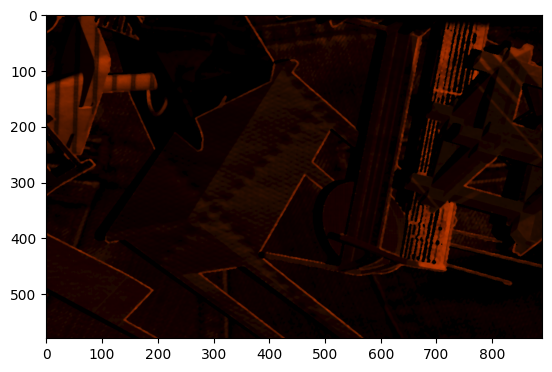

In [24]:
c_idx = 2
plt.imshow(hdr_imgs_filtered_array[c_idx]/24)

In [25]:
# np.save('hdr_imgs_filtered_array.npy', hdr_imgs_filtered_array)

In [26]:
hdr_imgs = hdr_imgs_filtered_array

#### Depth

In [27]:
depth = np.load(os.path.join(data_dir,'depth.npy'))*1e+3

(<Figure size 300x200 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x2093b0bab88>)

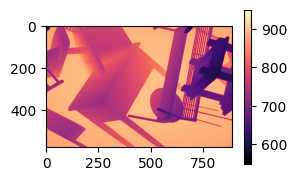

In [28]:
plt.figure(figsize=(3,2)), plt.imshow(depth, vmin = 550, vmax = 950, cmap='magma'), plt.colorbar()

In [29]:
depth = np.round(depth).reshape(cam_H* cam_W).astype(np.int16)

#### Depth dependent peak illumination index

In [30]:
valid_idx_final =valid_idx_final.reshape(3, 24, 580, 890)

In [31]:
valid_idx_final.shape, valid_mask_reshape.shape

((3, 24, 580, 890), (3, 24, 580, 890))

In [32]:
zero_real_img_illum_idx = np.repeat(valid_idx_final[1,0][np.newaxis,:,:], 7, axis=0)[:,np.newaxis,:,:]
first_real_img_illum_idx =  np.zeros(shape=(wvls_n, cam_H *cam_W))
valid_idx_final = valid_idx_final.reshape(m_n, wvls_n, cam_H*cam_W)

In [33]:
for i in range(cam_H * cam_W):
    if -1 in valid_idx_final[0,:,i]:
        if -1 in valid_idx_final[2,:,i]:
            m_count = np.count_nonzero(valid_idx_final[0,:,i] == -1) 
            f_count = np.count_nonzero(valid_idx_final[2,:,i] == -1)
            if m_count > f_count:
                first_real_img_illum_idx[:,i] = valid_idx_final[0,:,i]
            else:
                first_real_img_illum_idx[:,i] = valid_idx_final[2,:,i]
        else:
            first_real_img_illum_idx[:,i] = valid_idx_final[2,:,i]
    
    elif -1 in valid_idx_final[2,:,i]:
        if -1 in valid_idx_final[0,:,i]:
            m_count = np.count_nonzero(valid_idx_final[0,:,i] == -1) 
            f_count = np.count_nonzero(valid_idx_final[2,:,i] == -1)
            if m_count > f_count:
                first_real_img_illum_idx[:,i] = valid_idx_final[0,:,i]
            else:
                first_real_img_illum_idx[:,i] = valid_idx_final[2,:,i]
        else:
            first_real_img_illum_idx[:,i] = valid_idx_final[0,:,i]
              
    else:
        m_count = np.count_nonzero(valid_idx_final[0,:,i] == -1) 
        f_count = np.count_nonzero(valid_idx_final[2,:,i] == -1)
        if m_count > f_count:
            first_real_img_illum_idx[:,i] = valid_idx_final[0,:,i]
        else:
            first_real_img_illum_idx[:,i] = valid_idx_final[2,:,i]

In [34]:
mask_idx = np.ones(shape=(len(new_wvls), cam_H*cam_W))
first_real_img_illum_idx_reshape =  first_real_img_illum_idx.reshape(wvls_n, cam_H*cam_W)

for i in range(cam_W*cam_H):
    if -1 in first_real_img_illum_idx[:,i]:
        idx = np.where(first_real_img_illum_idx[:,i] == -1)[0]
        first_real_img_illum_idx[idx,i] = first_real_img_illum_idx[idx[0]-1,i]
        mask_idx[idx,i] = 0

In [35]:
zero_real_img_illum_idx.shape

(7, 1, 580, 890)

In [36]:
zero_real_img_illum_idx_final = np.repeat(zero_real_img_illum_idx.reshape(n_illum, cam_W*cam_H)[:,:,np.newaxis], 3, axis = 2)
zero_real_img_illum_idx_final = zero_real_img_illum_idx_final.astype(np.int16).reshape(n_illum, cam_H, cam_W, 3)

In [37]:
hdr_imgs.shape, zero_real_img_illum_idx_final.shape

((7, 580, 890, 3), (7, 580, 890, 3))

### GT RGB ZERO

In [38]:
x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')

GT_I_RGB_ZERO = np.zeros(shape=(len(colors), cam_H, cam_W, 1, 3))
for c in range(len(colors)):
    GT_I_RGB_ZERO[c] =  hdr_imgs[c][:,:,np.newaxis]

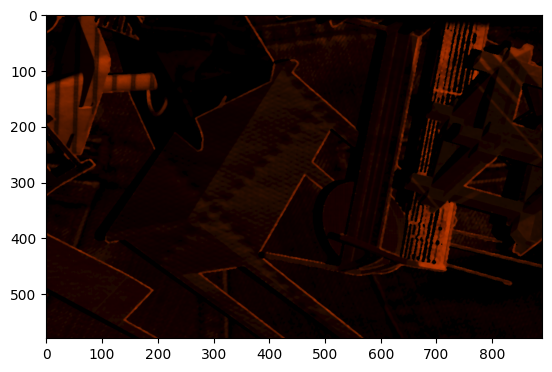

In [39]:
plt.imshow(hdr_imgs[2]/24)

In [40]:
first_real_img_illum_idx_reshape = first_real_img_illum_idx.reshape(len(new_wvls), cam_H*cam_W)
zero_real_img_illum_idx_flatt = zero_real_img_illum_idx.flatten()
# DG efficiency for all pixels
DG_efficiency_image_first = np.zeros(shape=(cam_H * cam_W, len(new_wvls)))
DG_efficiency_image_zero = np.ones(shape=(cam_H * cam_W, len(new_wvls))) # * (max(DG_efficiency[0].sum(), DG_efficiency[2].sum()) / 47)

dg_scalar = 1+0.5*(DG_efficiency[2]-DG_efficiency[0])

for i in tqdm(range(cam_H * cam_W)):
    if zero_real_img_illum_idx_flatt[i] > first_real_img_illum_idx_reshape[0,i]: # 430nm # -1 order
        DG_efficiency_image_first[i,:] =  DG_efficiency[0]
    elif zero_real_img_illum_idx_flatt[i] < first_real_img_illum_idx_reshape[0,i]: # +1 order
        DG_efficiency_image_first[i,:] =  DG_efficiency[2]  #dg_scalar
    else: # else
        DG_efficiency_image_first[i,:] = 0

  0%|          | 0/516200 [00:00<?, ?it/s]

100%|██████████| 516200/516200 [00:00<00:00, 1441498.96it/s]


In [41]:
START OPTIMIZATION

SyntaxError: invalid syntax (2240033188.py, line 1)

In [42]:
patt_colors = np.zeros(shape=(len(colors), cam_H*cam_W, 3))
constant = 0.8

for c_idx, c in enumerate(colors):
    if c == 'white':
        patt_colors[c_idx,:,0] = 1 * constant
        patt_colors[c_idx,:,1] = 1 * constant
        patt_colors[c_idx,:,2] = 1 * constant
        
    elif c== 'green':
        patt_colors[c_idx,:,0] = 0 * constant
        patt_colors[c_idx,:,1] = 1 * constant
        patt_colors[c_idx,:,2] = 0 * constant

    elif c== 'red':
        patt_colors[c_idx,:,0] = 1 * constant
        patt_colors[c_idx,:,1] = 0 * constant
        patt_colors[c_idx,:,2] = 0 * constant

    elif c== 'blue':
        patt_colors[c_idx,:,0] = 0 * constant
        patt_colors[c_idx,:,1] = 0 * constant
        patt_colors[c_idx,:,2] = 1 * constant

    elif c== 'cyan':
        patt_colors[c_idx,:,0] = 0 * constant
        patt_colors[c_idx,:,1] = 1 * constant
        patt_colors[c_idx,:,2] = 1 * constant

    elif c== 'yellow':
        patt_colors[c_idx,:,0] = 1 * constant
        patt_colors[c_idx,:,1] = 1 * constant
        patt_colors[c_idx,:,2] = 0 * constant

    else:        
        patt_colors[c_idx,:,0] = 1 * constant
        patt_colors[c_idx,:,1] = 0 * constant
        patt_colors[c_idx,:,2] = 1 * constant

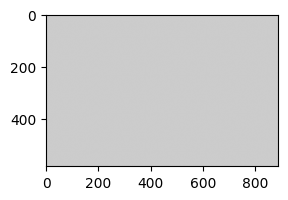

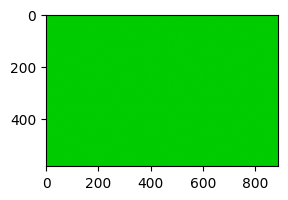

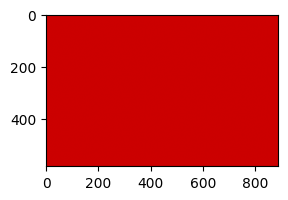

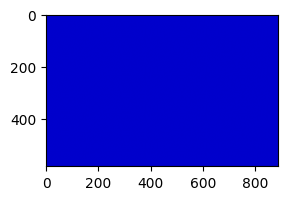

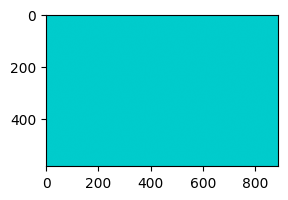

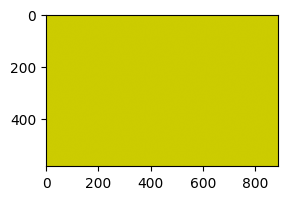

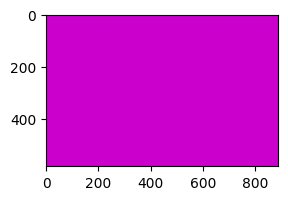

In [43]:
for c in range(len(colors)):
    plt.figure(figsize=(3,2))
    plt.imshow(patt_colors[c].reshape(cam_H, cam_W, 3))

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch : 0/600, Loss: 31.213715251240135, LR: 0.04


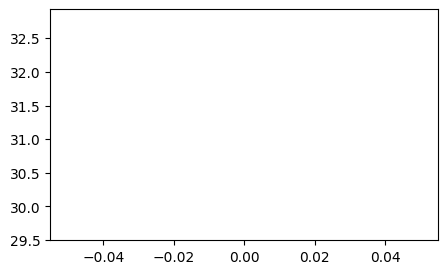

Epoch : 10/600, Loss: 7.4216547349447595, LR: 0.04
Epoch : 20/600, Loss: 4.704624052199914, LR: 0.04
Epoch : 30/600, Loss: 2.7669640596377194, LR: 0.04
Epoch : 40/600, Loss: 1.442473478752226, LR: 0.04
Epoch : 50/600, Loss: 1.1190979356040376, LR: 0.04
Epoch : 60/600, Loss: 0.903535811846959, LR: 0.04
Epoch : 70/600, Loss: 0.8434724167988121, LR: 0.04
Epoch : 80/600, Loss: 0.8071499001284893, LR: 0.04
Epoch : 90/600, Loss: 0.7894670836104895, LR: 0.04
Epoch : 100/600, Loss: 0.7796626298096963, LR: 0.04


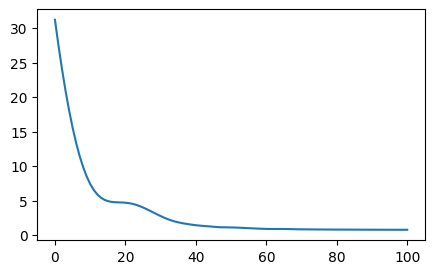

Epoch : 110/600, Loss: 0.7746761661680407, LR: 0.04
Epoch : 120/600, Loss: 0.7728153089374622, LR: 0.04
Epoch : 130/600, Loss: 0.7719342370690485, LR: 0.04
Epoch : 140/600, Loss: 0.7718676751586566, LR: 0.04
Epoch : 150/600, Loss: 0.771603301276794, LR: 0.04
Epoch : 160/600, Loss: 0.7712798192254707, LR: 0.04
Epoch : 170/600, Loss: 0.7716128123312935, LR: 0.04
Epoch : 180/600, Loss: 0.77136484655728, LR: 0.04
Epoch : 190/600, Loss: 0.771529685853896, LR: 0.04
Epoch : 200/600, Loss: 0.7719808773156577, LR: 0.04


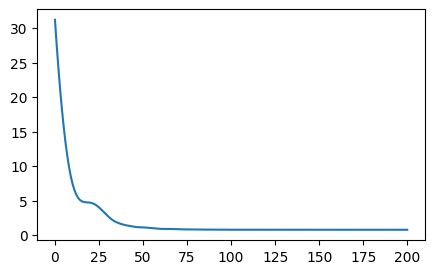

Epoch : 210/600, Loss: 0.7720517792312769, LR: 0.04
Epoch : 220/600, Loss: 0.7715704125691439, LR: 0.04
Epoch : 230/600, Loss: 0.7720575997549555, LR: 0.04
Epoch : 240/600, Loss: 0.7724497740630788, LR: 0.04
Epoch : 250/600, Loss: 0.7719757736182121, LR: 0.04
Epoch : 260/600, Loss: 0.7724284219128729, LR: 0.04
Epoch : 270/600, Loss: 0.7726464548470693, LR: 0.04
Epoch : 280/600, Loss: 0.7723581504378877, LR: 0.04
Epoch : 290/600, Loss: 0.7728457116600329, LR: 0.04
Epoch : 300/600, Loss: 0.7730257888643204, LR: 0.04


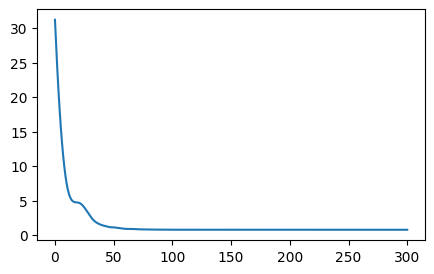

Epoch : 310/600, Loss: 0.7726815786706023, LR: 0.04
Epoch : 320/600, Loss: 0.7728435817825468, LR: 0.04
Epoch : 330/600, Loss: 0.7727453423213969, LR: 0.04
Epoch : 340/600, Loss: 0.7731712242486296, LR: 0.04
Epoch : 350/600, Loss: 0.772955964708999, LR: 0.04
Epoch : 360/600, Loss: 0.7736131611005536, LR: 0.04
Epoch : 370/600, Loss: 0.7731311801334573, LR: 0.04
Epoch : 380/600, Loss: 0.772943639740508, LR: 0.04
Epoch : 390/600, Loss: 0.7735033366728146, LR: 0.04
Epoch : 400/600, Loss: 0.7730008809665992, LR: 0.02


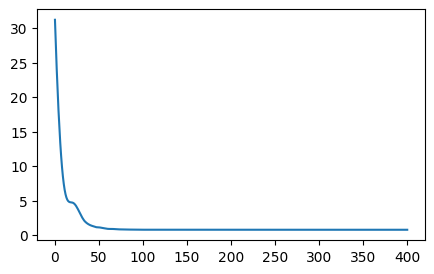

Epoch : 410/600, Loss: 0.7637407886157941, LR: 0.02
Epoch : 420/600, Loss: 0.7618053660325725, LR: 0.02
Epoch : 430/600, Loss: 0.7611203004461207, LR: 0.02
Epoch : 440/600, Loss: 0.7606979277986102, LR: 0.02
Epoch : 450/600, Loss: 0.7607580682590976, LR: 0.02
Epoch : 460/600, Loss: 0.7607771785630689, LR: 0.02
Epoch : 470/600, Loss: 0.7606544186251641, LR: 0.02
Epoch : 480/600, Loss: 0.7607311864467958, LR: 0.02
Epoch : 490/600, Loss: 0.7606212218072735, LR: 0.02
Epoch : 500/600, Loss: 0.7607330193207504, LR: 0.02


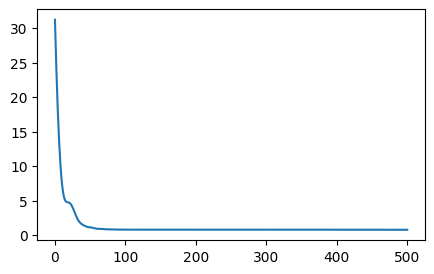

Epoch : 510/600, Loss: 0.7606838365762063, LR: 0.02
Epoch : 520/600, Loss: 0.7609445313275764, LR: 0.02
Epoch : 530/600, Loss: 0.7610515054083945, LR: 0.02
Epoch : 540/600, Loss: 0.7612604246608642, LR: 0.02
Epoch : 550/600, Loss: 0.7611865995521213, LR: 0.02
Epoch : 560/600, Loss: 0.7611870082171582, LR: 0.02
Epoch : 570/600, Loss: 0.7611262371338435, LR: 0.02
Epoch : 580/600, Loss: 0.7611487969625861, LR: 0.02
Epoch : 590/600, Loss: 0.7611647104055523, LR: 0.02


In [107]:
import random
# arguments
device = 'cuda:0'
epoch = 600 #2000
loss_f = torch.nn.L1Loss()
losses = [] 

# Height, width of image
H, W = 1, 1

# learning rate & decay step
lr = 0.04 # 0.03
decay_step = 400
gamma = 0.5

# initial_value = torch.ones(size =(cam_H*cam_W, len(new_wvls)))/2
initial_value = torch.ones(size =(cam_H*cam_W, pca.components_.shape[0]))/2
_opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# basis vector
basis = torch.tensor(pca.components_, dtype = torch.float).to(device).unsqueeze(dim = 0)

# optimizer and schedular
optimizer = torch.optim.Adam([_opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# shape : 3, 47
PEF_dev = torch.tensor(PEF, dtype = torch.float).to(device).T
CRF_dev = torch.tensor(CRF, dtype = torch.float).to(device)
# DG_efficiency_zero_dev = torch.tensor(DG_efficiency_image_zero.reshape(cam_H*cam_W, -1), device=device)

# depth scalar
A =  7.5 * 1e+5 # 10 * 1e+5 for peak # 4 * 1e+5 for tree
depth_scalar = ((depth.astype(np.int32))**2) / A

depth_scalar_dev = torch.tensor(depth_scalar, dtype = torch.float).to(device).T
# depth_scalar_dev = torch.ones_like(depth_scalar_dev, dtype = torch.float)

# white pattern into multi-spectral channels
patt_colors_dev = torch.tensor(patt_colors, dtype = torch.float, device=device)
patt_colors_hyp = patt_colors_dev @ PEF_dev
# patt_colors_hyp = patt_colors_hyp.squeeze()

GT_I_RGB_ZERO_tensor = torch.tensor(GT_I_RGB_ZERO, device=device)

rand_idx = [random.randint(0, 21) for _ in range(5)]

weight_spectral = 50 # 50

loss_vis = []
pcamean = torch.tensor(pca.mean_, device=device, dtype=torch.float)
for i in range(epoch):
    # initial loss
    loss = 0

    # opt_param = _opt_param.unsqueeze(dim = -1)
    
    # PCA
    opt_param = _opt_param.unsqueeze(dim = -1)
    ref = (torch.mm(opt_param[...,0], basis[0]) + pcamean).unsqueeze(dim=-1)
    # ref = torch.sigmoid(ref)
    
    for c in range(len(colors)):
        # white pattern into multi-spectral channels
        patt_hyp = patt_colors_hyp[c]
        
        A_zero = CRF_dev.unsqueeze(dim = 0) * patt_hyp.unsqueeze(dim = -1) #* DG_efficiency_zero_dev.unsqueeze(dim = -1)
        
        # PCA
        Simulated_I_RGB_zero = torch.sum(ref * A_zero / depth_scalar_dev.unsqueeze(dim = -1).unsqueeze(dim = -1), axis=1) 
        
        zero_loss = torch.abs((Simulated_I_RGB_zero.reshape(cam_H, cam_W, 1, 3)) - GT_I_RGB_ZERO_tensor[c]) / (cam_H*cam_W)
        loss +=  zero_loss.sum()
        
        hyp_dL2 = ((ref[:,:-1] - ref[:,1:])**2).sum()/(cam_H*cam_W)
        loss += weight_spectral*(hyp_dL2)

    loss = loss.sum() / len(colors)
    loss_vis.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    scheduler.step()
        
    if i % 10 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")
        
        if i % 100 == 0:
            plt.figure(figsize=(5,3))
            plt.plot(loss_vis)
            plt.show()

### Visualization

In [108]:
opt_param_detach = opt_param.detach().cpu().numpy()
basis_detach = basis.detach().cpu().numpy()

In [109]:
opt_param_detach.shape, basis.shape

((516200, 8, 1), torch.Size([1, 8, 24]))

In [110]:
opt_param_detach.shape

(516200, 8, 1)

In [111]:
ref = pca.inverse_transform(opt_param_detach[...,0])

In [112]:
ref = (opt_param_detach*basis_detach).sum(axis = 1)
# ref = opt_param_detach

In [113]:
np.save('../opt_param.npy', ref.reshape(cam_H, cam_W, wvls_n))

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


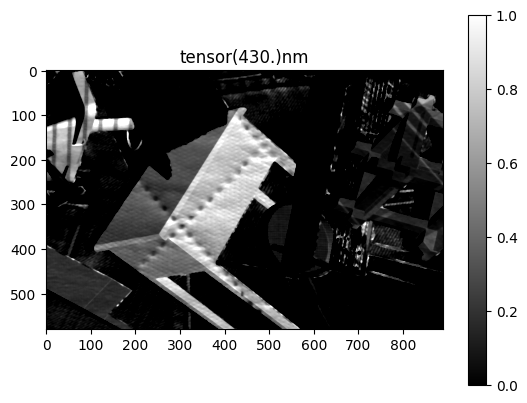

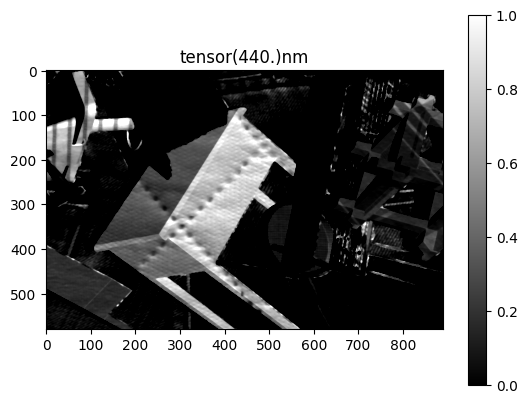

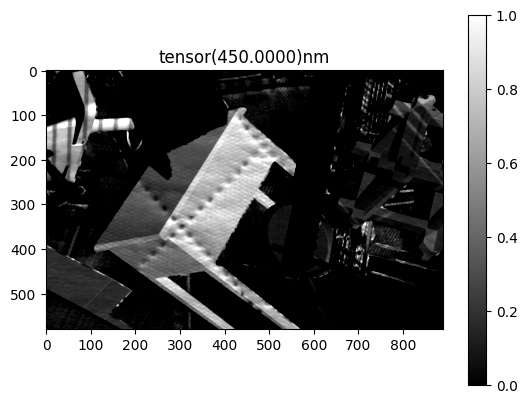

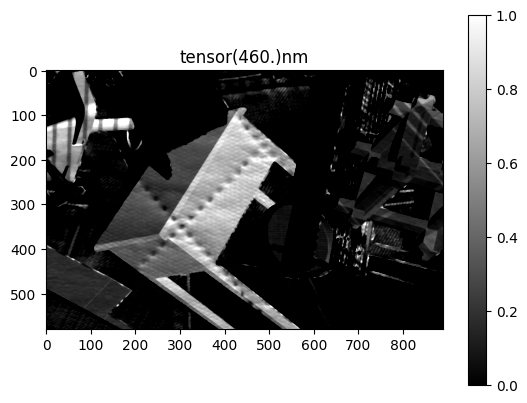

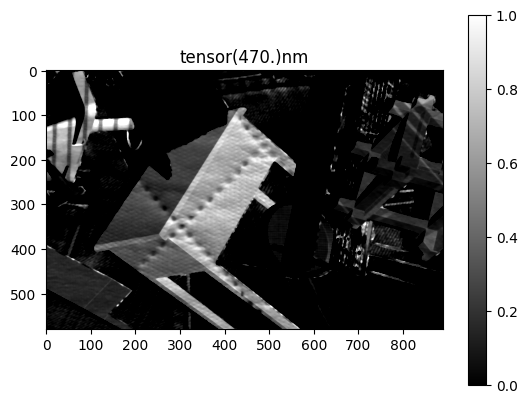

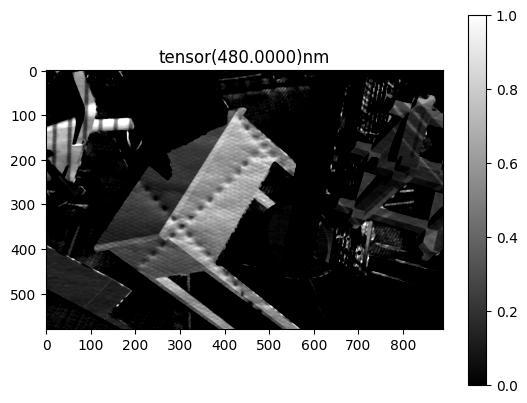

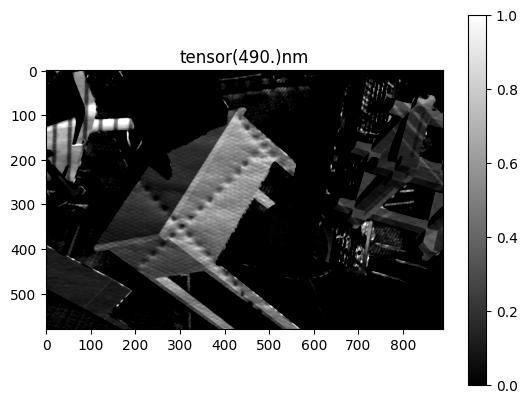

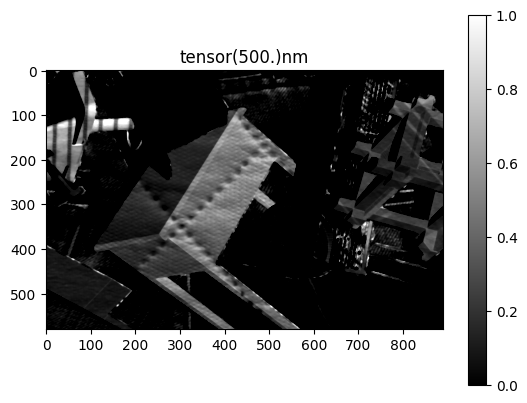

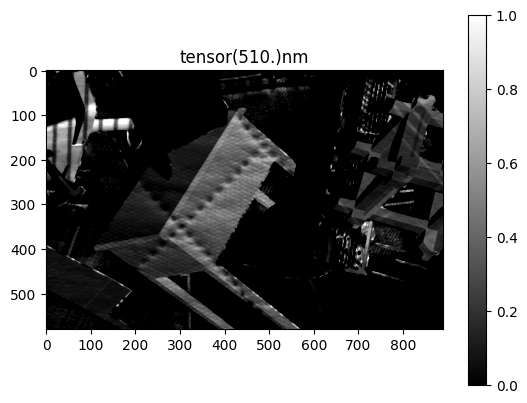

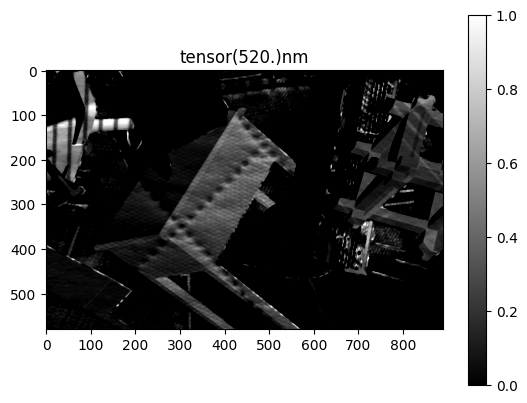

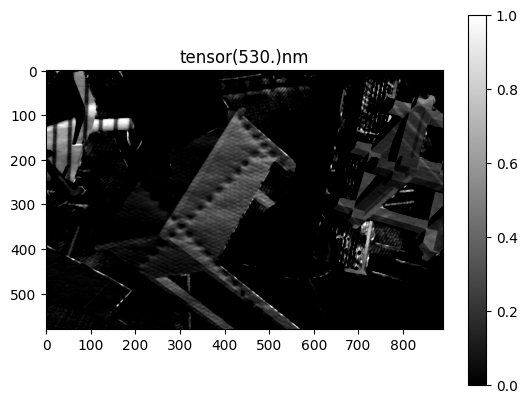

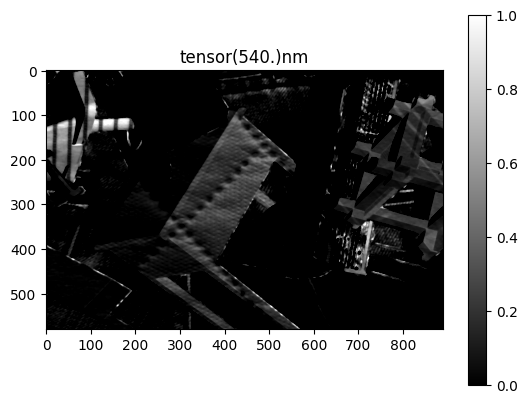

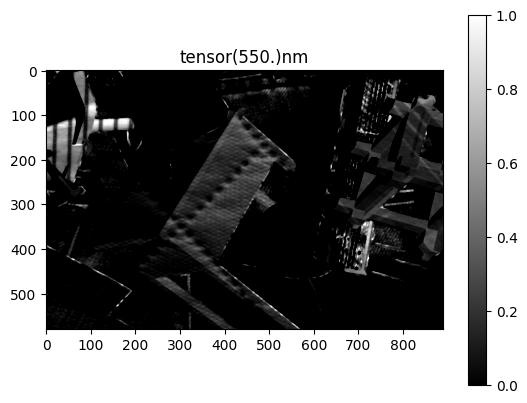

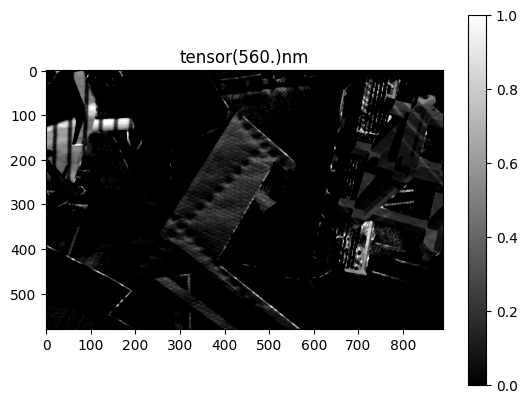

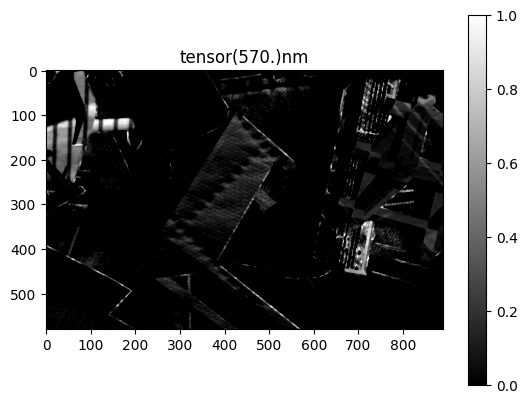

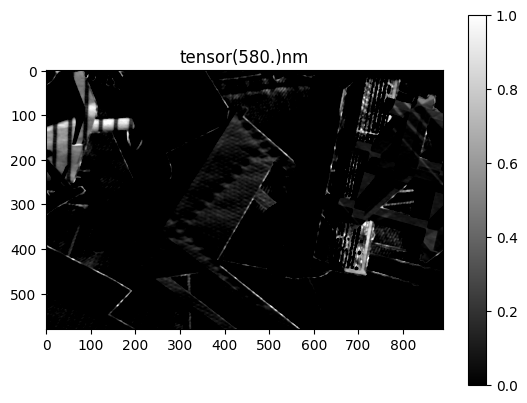

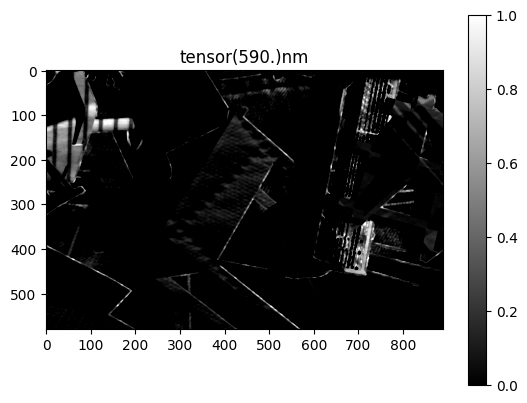

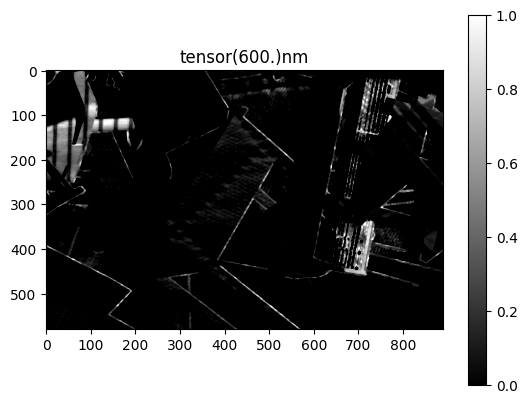

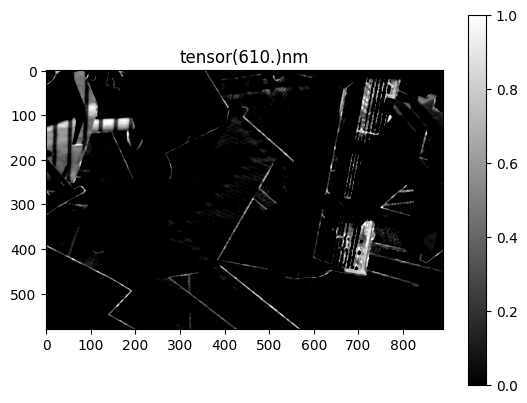

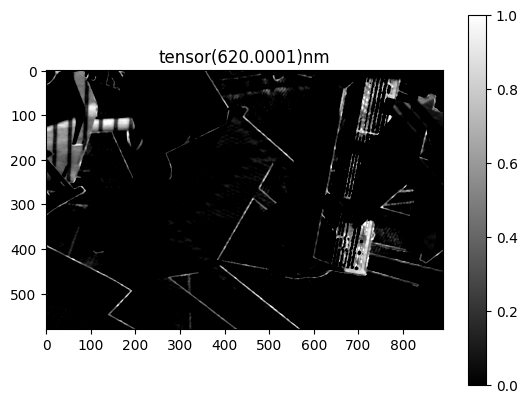

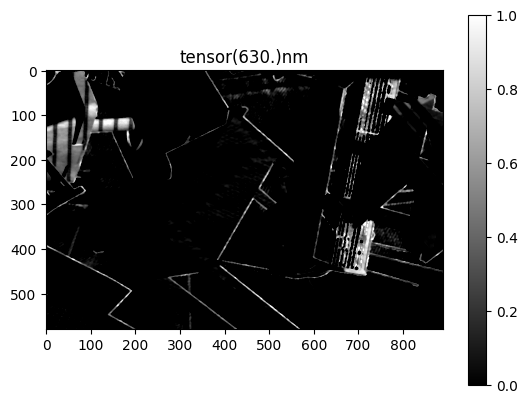

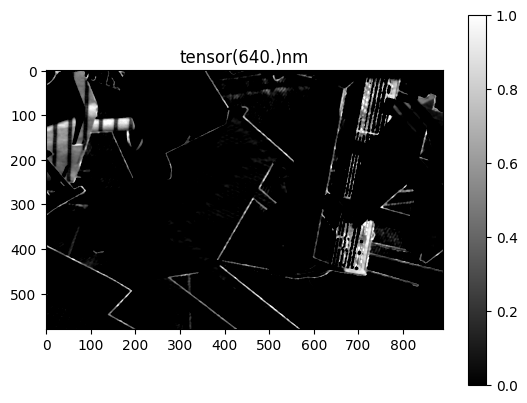

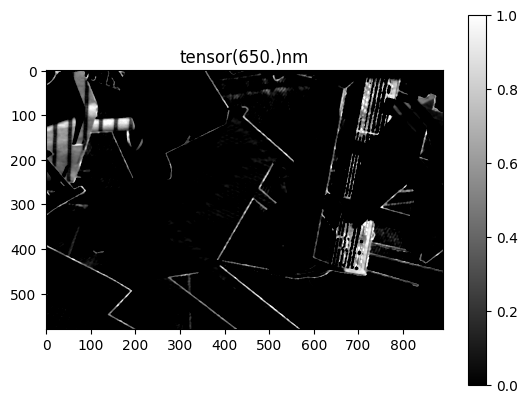

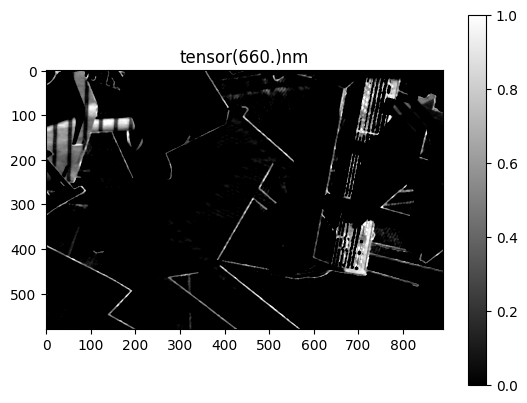

In [114]:
for i in range(len(new_wvls)):
    plt.figure()
    plt.imshow(ref.reshape(cam_H, cam_W, len(new_wvls))[:,:,i], vmin = 0, vmax = 1, cmap = 'gray'), plt.title('%snm'%(new_wvls[i]*1e9)), plt.colorbar()

In [115]:
from scipy.io import savemat

savemat('../CASSI/x_recon_procam.mat', {'x_recon':ref.reshape(580, 890, len(new_wvls))})

### RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


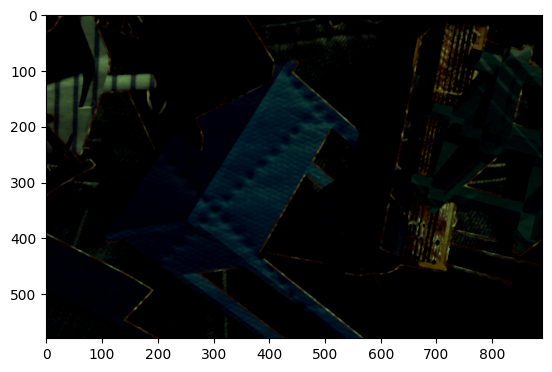

In [116]:
rgb_img = ref@CRF

plt.figure()
plt.imshow(rgb_img.reshape(cam_H, cam_W,3)*0.02)
# plt.savefig('./rgb.png')

### Compare GT

In [117]:
ref = np.load('../opt_param.npy')

In [118]:
hyp_gt = np.array([cv2.imread('../CASSI/hyp_shading_gt/%02d.png'%i,-1)/255 for i in range(wvls_n)])

In [119]:
# ref = np.clip(ref, 0, 1)

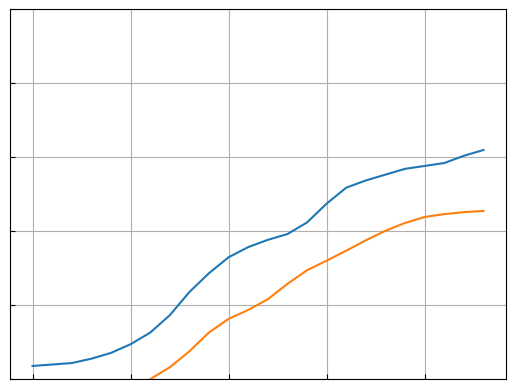

In [120]:
H, W = 120, 140
H, W = 58, 664
# H, W = 300, 200
# H, W = 155, 120

fig, ax = plt.subplots()
plt.ylim([0,1])
plt.plot(hyp_gt[:,H,W], label = 'gt')
plt.plot(ref.reshape(cam_H, cam_W, wvls_n)[H,W]*0.6, label = 'estimated')
plt.grid()

# Erasing y-axis and x-axis labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Setting ticks direction to inward
ax.tick_params(axis='x', direction='in')
ax.tick_params(axis='y', direction='in')
    
# plt.legend()